## [Homework](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/06-best-practices/homework.md)
In this homework, we'll take the ride duration prediction model that we deployed in batch mode in homework 4 and improve the reliability of our code with unit and integration tests.

You'll find the starter code in the [homework](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/06-best-practices/homework) directory.

## Q1. Refactoring
Before we can start covering our code with tests, we need to refactor it. We'll start by getting rid of all the global variables.

Let's create a function ```main``` with two parameters: ```year``` and ```month```.
Move all the code (except ```read_data```) inside ```main```
Make ```categorical``` a parameter for ```read_data``` and pass it inside ```main```
Now we need to create the "main" block from which we'll invoke the main function. How does the if statement that we use for this looks like?

if __name__ == '__main__':
    year = int(sys.argv[1])
    month = int(sys.argv[2])
    main(year, month)

In [1]:
import sys
import pickle
import pandas as pd

In [2]:
def main (year, month):
    year = int(sys.argv[1])
    month = int(sys.argv[2])
    
    input_file = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year:04d}-{month:02d}.parquet'
    output_file = f'output/yellow_tripdata_{year:04d}-{month:02d}.parquet'
    
    with open('model.bin', 'rb') as f_in:
        dv, lr = pickle.load(f_in)

    categorical = ['PULocationID', 'DOLocationID']
    

def read_data(filename, categorical):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

## Q2. Installing pytest
Now we need to install pytest:

bash```
pipenv install --dev pytest```

Next, create a folder tests and create two files. One will be the file with tests. We can name it test_batch.py.

What should be the other file?

### Answer:

```__init__.py```

## Q3. Writing first unit test
Now let's cover our code with unit tests.

We'll start with the pre-processing logic inside read_data.

It's difficult to test right now because first reads the file and then performs some transformations. We need to split this code into two parts: reading (I/O) and transformation.

So let's create a function prepare_data that takes in a dataframe (and some other parameters too) and applies some transformation to it.

(That's basically the entire read_data function after reading the parquet file)

Now create a test and use this as input:

In [6]:
import pandas as pd 
from datetime import datetime

from datetime import datetime

def dt(hour, minute, second=0):
    return datetime(2023, 1, 1, hour, minute, second)


data = [
    (None, None, dt(1, 1), dt(1, 10)),
    (1, 1, dt(1, 2), dt(1, 10)),
    (1, None, dt(1, 2, 0), dt(1, 2, 59)),
    (3, 4, dt(1, 2, 0), dt(2, 2, 1)),      
]

columns = ['PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
df = pd.DataFrame(data, columns=columns)

In [8]:
df

,PULocationID,DOLocationID,tpep_pickup_datetime,tpep_dropoff_datetime
0,NaN,NaN,2023-01-01 01:01:00,2023-01-01 01:10:00
1,1.0,1.0,2023-01-01 01:02:00,2023-01-01 01:10:00
2,1.0,NaN,2023-01-01 01:02:00,2023-01-01 01:02:59
3,3.0,4.0,2023-01-01 01:02:00,2023-01-01 02:02:01


In [10]:
df_out = pd.read_parquet('/workspaces/mlops_zoomcamp_2024/06-best_practice/homework/predicted_data/taxi_type=yellow_year={year:04d}_month={month:02d}.parquet')

In [13]:
df_out

,ride_id,predicted_duration
0,2023/03_0,16.245906
1,2023/03_1,26.134796
2,2023/03_2,11.884264
3,2023/03_3,11.997720
4,2023/03_4,10.234486
...,...,...
3316211,2023/03_3403761,11.952635
3316212,2023/03_3403762,20.049958
3316213,2023/03_3403763,11.595336
3316214,2023/03_3403764,13.113178


Create a first unit test

In [ ]:
import pytest
import pandas as pd
from datetime import datetime

def dt(hour, minute, second=0):
    return datetime(2023, 1, 1, hour, minute, second)

def prepare_data(df, categorical):
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].dt.total_seconds() / 60

    # Фильтрация по длительности поездки
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)].copy()

    # Преобразование столбцов categorical в строковый тип
    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df


def test_prepare():
    # Test data
    test_data = [
        (None, None, dt(1, 1), dt(1, 10)),   # поездка 9 минут (подходит)
        (1, 1, dt(1, 2), dt(1, 10)),         # поездка 8 минут (подходит)
        (1, None, dt(1, 2, 0), dt(1, 2, 59)),# поездка 59 секунд (не подходит)
        (3, 4, dt(1, 2, 0), dt(2, 2, 1)),    # поездка 24 часа и 1 секунда (не подходит)
    ]

    columns = ['PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
    test_df = pd.DataFrame(test_data, columns=columns)

    # Expected data
    expected_data = [
        (-1, -1, dt(1, 1), dt(1, 10), 9.0),  # поездка 9 минут
        (1, 1, dt(1, 2), dt(1, 10), 8.0),       # поездка 8 минут
    ]

    expected_columns = ['PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'duration']
    expected_df = pd.DataFrame(expected_data, columns=expected_columns)
    expected_df['PULocationID'] = expected_df['PULocationID'].astype(str)
    expected_df['DOLocationID'] = expected_df['DOLocationID'].astype(str)

    # Run function
    categorical = ['PULocationID', 'DOLocationID']
    result_df = prepare_data(test_df, categorical)

    # Assert the result
    pd.testing.assert_frame_equal(result_df, expected_df, check_dtype=True)



if __name__ == "__main__":
    pytest.main([__file__])


How many rows should be there in the expected dataframe?

- 1
- 2
- 3
- 4

### Answer:
- 2

## Q4. Mocking S3 with Localstack
Now let's prepare for an integration test. In our script, we write data to S3. So we'll use Localstack to mimic S3.

First, let's run Localstack with Docker compose. Let's create a docker-compose.yaml file with just one service: localstack. Inside localstack, we're only interested in running S3.

Start the service and test it by creating a bucket where we'll keep the output. Let's call it "nyc-duration".

With AWS CLI, this is how we create a bucket:

```aws s3 mb s3://nyc-duration```

Then we need to check that the bucket was successfully created. With AWS, this is how we typically do it:



```aws s3 ls```

In both cases we should adjust commands for localstack. What option do we need to use for such purposes?
```
--backend-store-uri
--profile
--endpoint-url
--version
```

### Answer:
- --endpoint-url


## Make input and output paths configurable
Right now the input and output paths are hardcoded, but we want to change it for the tests.

One of the possible ways would be to specify ```INPUT_FILE_PATTERN``` and ```OUTPUT_FILE_PATTERN``` via the env variables. Let's do that:

```
export INPUT_FILE_PATTERN="s3://nyc-duration/in/{year:04d}-{month:02d}.parquet"
export OUTPUT_FILE_PATTERN="s3://nyc-duration/out/{year:04d}-{month:02d}.parquet"

 ```

And this is how we can read them:



In [ ]:

def get_input_path(year, month):
    default_input_pattern = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year:04d}-{month:02d}.parquet'
    input_pattern = os.getenv('INPUT_FILE_PATTERN', default_input_pattern)
    return input_pattern.format(year=year, month=month)


def get_output_path(year, month):
    default_output_pattern = 's3://nyc-duration-prediction-alexey/taxi_type=fhv/year={year:04d}/month={month:02d}/predictions.parquet'
    output_pattern = os.getenv('OUTPUT_FILE_PATTERN', default_output_pattern)
    return output_pattern.format(year=year, month=month)


def main(year, month):
    input_file = get_input_path(year, month)
    output_file = get_output_path(year, month)
    # rest of the main function ... 

## Reading from Localstack S3 with Pandas


So far we've been reading parquet files from S3 with using pandas read_parquet. But this way we read it from the actual S3 service. Now we need to replace it with our localstack one.

For that, we need to specify the endpoint url:

In [ ]:
options = {
    'client_kwargs': {
        'endpoint_url': S3_ENDPOINT_URL
    }
}

df = pd.read_parquet('s3://bucket/file.parquet', storage_options=options)

Let's modify our read_data function:

- check if S3_ENDPOINT_URL is set, and if it is, use it for reading
- otherwise use the usual way

## Q5. Creating test data

Now let's create ``integration_test.py``

We'll use the dataframe we created in Q3 (the dataframe for the unit test) and save it to S3. You don't need to do anything else: just create a dataframe and save it.

We will pretend that this is data for January 2023.

Run the ```integration_test.py``` script. After that, use AWS CLI to verify that the file was created.

Use this snipped for saving the file:

In [ ]:
df_input.to_parquet(
    input_file,
    engine='pyarrow',
    compression=None,
    index=False,
    storage_options=options
)

What's the size of the file?

- 3620
- 23620
- 43620
- 63620

### Answer:

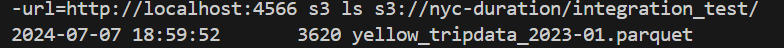

- 3620

## Q6. Finish the integration test

We can read from our localstack s3, but we also need to write to it.

Create a function ```save_data``` which works similarly to ```read_data```, but we use it for saving a dataframe.

Let's run the ```batch.py``` script for January 2023 (the fake data we created in Q5).

We can do that from our integration test in Python: we can use ```os.system``` for doing that (there are other options too).

Now it saves the result to localstack.

The only thing we need to do now is to read this data and verify the result is correct.


What's the sum of predicted durations for the test dataframe?

- 13.08
- 36.28
- 69.28
- 81.08

Read the data from s3

In [7]:
import pandas as pd
import boto3
import io


def read_from_s3(bucket_name, key, endpoint_url='http://localhost:4566'):
    s3_client = boto3.client('s3', endpoint_url=endpoint_url)
    
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    
    data = response['Body'].read()
    
    df = pd.read_parquet(io.BytesIO(data))
    
    return df

In [9]:
df = read_from_s3('nyc-duration', 'predicted_data/taxi_type=yellow_year=2023_month=01.parquet')

In [10]:
df

,ride_id,predicted_duration
0,2023/01_0,23.197149
1,2023/01_1,13.080101


In [13]:
df.predicted_duration.sum().round(2)

36.28

### Answer:
- 36.28